#Hopfield networks

Now we arrive at the culmination of our efforts. In the first three weeks we grappled with the fundamentals needed to bring us to this point.

First, we discussed the necessary concepts of emergence: how interesting properties of a system can result from the interaction of the parts of that system. It is essential that we pay attention to both the (low level) details of how a system works, and the (high level) details of what a system does as its overall function. Neuroscientists care about the brain. Psychologists care about the mind. We care about understanding both.

Second, we looked at the fundamental unit of brain function, the single neuron. We saw how we could model these units as simple information processors. As well as being an elegant simplification of much biological detail, this perspective also allows us to unite brain function with the universe of computation. Why is the brain like it is? Because it's primary job is collecting and passing on signals.

Third, we explored a mechanism for changing the connection strength (weight) between neurons: Hebb's Rule. We saw how this rule allows weights between neurons to encode co-occurance or correlation between their activities. If neuron activity is tied to events in the real world, then the weights will come to reflect the strength of association between those events. 

This final fact means that networks of neurons can act in ways where they seem to make predictions, where they have expectations about what is connected to what in the world. Networks of neurons - networks we can model - can be shown to have something like beliefs or memories. These are unlike beliefs or memories humans have, since they don't come with the ability to experience or feel, but maybe they can tell us something about how our own memories are generated...

We are going to create a run a network of model neurons called a Hopfield Network. 

In [1]:
from IPython.display import HTML
HTML('<iframe src=http://www.scholarpedia.org/article/Hopfield_network width=1000 height=350></iframe>')


In [2]:
'''
The code for running the Hopfield network is taken from Stefan Maetschke. Thanks Stefan!
http://codeaffectionate.blogspot.co.uk/2013/05/fun-with-hopfield-and-numpy.html

This will be the most complex code we have run so far, but it uses the basic principles we have already covered. 
The difference is that we now have a network of hundreds of model neurons, not just one or two

'''

#Import libraries we will use. 
# - remember, libraries are sets of functions we want to use in our code
# - functions are reusable sets of commands that do important tasks. 

import numpy as np #maths functions in python
import socket #to get host machine identity
import os # for joining paths and filenames sensibly
import glob #for finding files
import pylab as plt #graphing functions

#draw graphs in this notebook rather than in separate windows
%matplotlib inline


In [3]:
#previously we have also defined our own functions
#We're going to do that a lot here. 
#You don't need to follow each line of code, but do read the first line(s) which say what the code does

def from_jpg(name):
    #This function takes image files and converts them into a patter of numbers
    #We can then use this pattern of numbers to teach the Hopfield Network
    #need to make this so it forces square shape
    from PIL import Image
    size=40,40
    im = Image.open(name).convert('L')
    jm = im.resize(size,Image.ANTIALIAS)
    vals=np.array(jm.getdata())
    sgn = np.vectorize(lambda x: -1 if x<(255/2) else +1)
    return sgn(vals)

def to_pattern(letter):
    #This converts string to -1/+1 array
    from numpy import array
    return array([+1 if c=='X' else -1 for c in letter.replace('\n','')])
    
def display(pattern):
    #This shows a pattern of numbers as an image
    # - i.e it is the reverse of the 'from_jpg' function
    from pylab import imshow, cm, show
    side=int(np.sqrt(len(pattern)))    
    imshow(pattern.reshape((side,side)),cmap=cm.binary, interpolation='nearest')
    show()

def train(patterns):
    #This trains a network to remember the patterns it is given
    # - since it is important I'll comment each line
    from numpy import zeros, outer, diag_indices  #import functions for vector calculus
    r,c = patterns.shape #take the patters and make them vectors. There is a neuron for each pixel in the patterns
    W = zeros((c,c)) #there is a weight between each neuron in the network
    for p in patterns: # for each pattern
        W = W + outer(p,p) # change the weights to reflect the correlation between pixels
    W[diag_indices(c)] = 0 # neurons are not connected to themselves (ie the weight is 0)
    return W/r #send back the normalised weights
    
def recall(W, patterns, steps=5):
    #The tests the network. You give it a pattern and see what it produces
    from numpy import vectorize, dot #vector calculus functions
    sgn = vectorize(lambda x: -1 if x<0 else +1) # convert input pattern into a -1/+1 pattern
    for _ in xrange(steps): #over a number of iterations (defined by 'steps')    
        patterns = sgn(dot(patterns,W)) #adjust the neuron activity to reflect the weights
    return patterns #return the final pattern
    

def degrade(patterns,noise):
    #This allows you to add noise to a pattern
    sgn=np.vectorize(lambda x: x*-1 if np.random.random()<noise else x)
    out=sgn(patterns)
    return out

def degrade_weights(W,noise):
    #this function resets a proportion of the weights in the network
    sgn=vectorize(lambda x: 0 if random()<noise else x)
    return sgn(W)
    

def makepartial(p,proportion):
    u=int(proportion*len(p))
    new_p=p
    new_p[:u]=-1
    return new_p
    

We could train our Hopfiel network on any pattern. The neurons could be connected to any event, could represent any information. It is easiest to use visual patterns, though. Imagine that these are neurons which are connected to your visual system, so their activity normally reflects patterns of light and dark. What is another word for a pattern of light and dark? A picture!

So, first we need some pictures for our network to learn

<b>If you put your own jpg in the 'patterns' subdirectory the network will learn your picture as well</b>

In [4]:
#get files from 'patterns' directory. You can put your own pictures in there if you want
files = glob.glob(os.path.join('patterns','*.jpg')) #where are the patterns stored?

#from these files, define patterns of numbers
patterns=np.array([from_jpg(p) for p in files]) #put individual patterns in array

#remember how large the patterns are
side=int(np.sqrt(len(patterns[0]))) #assume all patterns the same shape


Let's have a look at our patterns

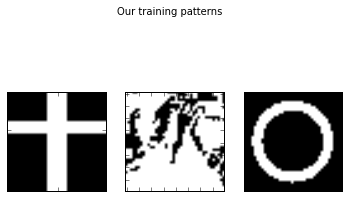

In [5]:
# Four axes, returned as a 2-d array
f, axarr = plt.subplots(1,len(patterns))

for p in range(len(patterns)):
    #axarr[0, p].imshow(patterns[p].reshape((side,side)),cmap=cm.binary, interpolation='nearest')
    axarr[p].imshow(patterns[p].reshape((side,side)), cmap="binary")
    #axarr[0, p].set_title('Cue' + str(p))
    
# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
plt.setp([a.get_xticklabels() for a in axarr[:]], visible=False)
plt.setp([a.get_yticklabels() for a in axarr[:]], visible=False)
plt.suptitle('Our training patterns')
plt.savefig('trainingpatterns.png') #save a file


The Hopfield Network learns patterns of association. In this case, the association is between pixels in the images.

In [6]:
print "train weights"

W = train(patterns) 


train weights


We have defined a network which has 'learnt' associations between pixels. Now the fun begins. We can explore the emergent properties of this network to see just what networks of simple neurons can do. We can ask if the way the Hopfield network behaves has any lessons to teach us about human memory.

#simple recall

In the graph below the first row shows the pattern the network is shown (the starting activity). The second row shows the pattern of activity after the neurons are allowed to send signals back and forth

test with originals


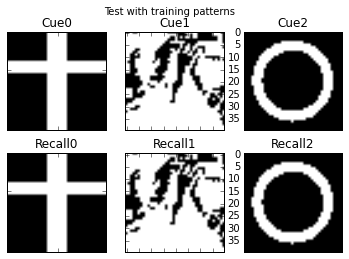

In [7]:
print "test with originals"

# Four axes, returned as a 2-d array
f, axarr = plt.subplots(2, len(patterns))

for p in range(len(patterns)):
    #axarr[0, p].imshow(patterns[p].reshape((side,side)),cmap=cm.binary, interpolation='nearest')
    axarr[0, p].imshow(patterns[p].reshape((side,side)), cmap="binary")
    axarr[0, p].set_title('Cue' + str(p))
    #axarr[1, p].imshow(recall(W,patterns)[p].reshape((side,side)),cmap=cm.binary, interpolation='nearest')
    axarr[1, p].imshow(recall(W,patterns)[p].reshape((side,side)), cmap="binary")
    axarr[1, p].set_title('Recall' + str(p))
# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
plt.setp([a.get_xticklabels() for a in axarr[1, :]], visible=False)
plt.setp([a.get_yticklabels() for a in axarr[:, 0]], visible=False)
plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)
plt.suptitle('Test with training patterns')
plt.savefig('fullcue.png')


They should match. Graphically this isn't very interesting, but it means that the network doesn't move away from the pattern it is shown if it has been trained it before. Is this something like what our memories do when we recognise something?

#Recognition with noisy inputs

You can recognise a face you've seen before in a new circumstances. You can recognise someone on a dark night, in the rain, even if they've changed their haircut. What does this mean to our network? Well, we can't give our patterns makeup, but we can alter them at random and see what how our network responds'

degrade patterns with noise


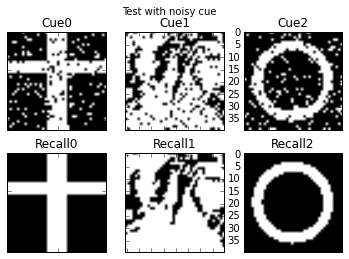

In [8]:
noise=0.1

#reload original patterns. 
#There's some variable reference / variable copying thing I don't understand that makes this necessary
patterns=np.array([from_jpg(p) for p in files]) #put individual patterns in array


print "degrade patterns with noise"
testpatterns=degrade(patterns,noise)

# Four axes, returned as a 2-d array
f, axarr = plt.subplots(2, len(patterns))

for p in range(len(testpatterns)):
    #axarr[0, p].imshow(patterns[p].reshape((side,side)),cmap=cm.binary, interpolation='nearest')
    axarr[0, p].imshow(testpatterns[p].reshape((side,side)), cmap="binary")
    axarr[0, p].set_title('Cue' + str(p))
    #axarr[1, p].imshow(recall(W,patterns)[p].reshape((side,side)),cmap=cm.binary, interpolation='nearest')
    axarr[1, p].imshow(recall(W,testpatterns)[p].reshape((side,side)), cmap="binary")
    axarr[1, p].set_title('Recall' + str(p))
# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
plt.setp([a.get_xticklabels() for a in axarr[1, :]], visible=False)
plt.setp([a.get_yticklabels() for a in axarr[:, 0]], visible=False)
plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)
plt.suptitle('Test with noisy cue')
plt.savefig('noisycue.png')


In the cell above the amount of noise is defined as 0.1. That's 10% of pixels randomly switched. What happens if you change that number? How is the system responding?

What you are seeing is sometimes called 'graceful degredation'. That means that the system fails gradually - it doesn't need the exact right inputs to guess the right pattern. Consider:

Yuo nca unredstnad thsi

Human information processing is often very good at coping with noisy inputs. Computers, not so much.


#Recognition from partial cues

In [9]:
print"test with partial cues"

proportion=0.4

#reload original patterns. 
#There's some variable reference / variable copying thing I don't understand that makes this necessary
patterns=np.array([from_jpg(p) for p in files]) #put individual patterns in array
   
testpatterns=[makepartial(p,proportion) for p in patterns]


 

test with partial cues


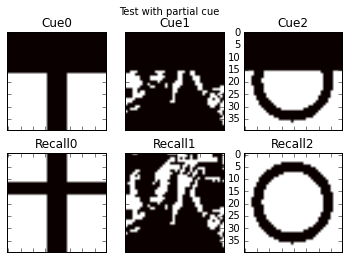

In [10]:
# Four axes, returned as a 2-d array
f, axarr = plt.subplots(2, len(testpatterns))

for p in range(len(testpatterns)):
    #axarr[0, p].imshow(patterns[p].reshape((side,side)),cmap=cm.binary, interpolation='nearest')
    axarr[0, p].imshow(testpatterns[p].reshape((side,side)), cmap="hot")
    axarr[0, p].set_title('Cue' + str(p))
    #axarr[1, p].imshow(recall(W,patterns)[p].reshape((side,side)),cmap=cm.binary, interpolation='nearest')
    axarr[1, p].imshow(recall(W,testpatterns)[p].reshape((side,side)), cmap="hot")
    axarr[1, p].set_title('Recall' + str(p))
# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
plt.setp([a.get_xticklabels() for a in axarr[1, :]], visible=False)
plt.setp([a.get_yticklabels() for a in axarr[:, 0]], visible=False)
plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)
plt.suptitle('Test with partial cue')
plt.savefig('partialcue.png')

So the network can recover the patterns it was trained on from a partial cue. Compare to how you can remember someone's name from their face, or the answer to the question "what is the capital of France?"

What happens as you change the amount of the original pattern that is removed?